# Plot model fit comparisons for simulation analysis 2

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mindstorm import statplot
from cfr import framework
from cfr import figures
from cfr import reports

fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()
%matplotlib inline

## Load model fits

In [2]:
included = ['DCMR-ICD', 'DCMR-Variable', 'DCMR-Restricted', 'CMR MP16']
models, model_names = framework.get_sim_models('cfr', 'set2', included=included)
all_models, all_model_names = framework.get_sim_models('cfr', 'set1')

## Plot model cross-validation performance

LINO NOT subset; don't know how to subset; dropped


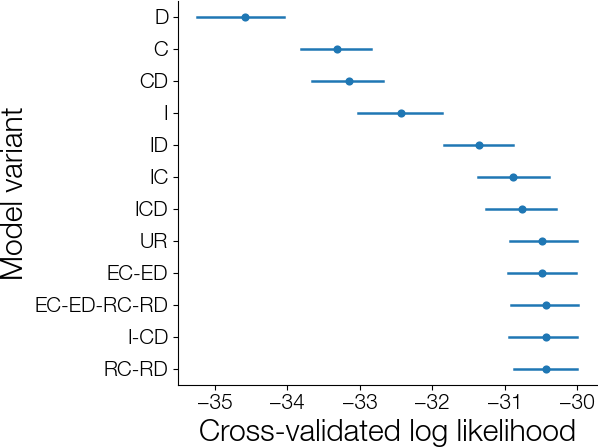

In [3]:
all_xval = framework.read_model_xvals(fit_dir, all_models, all_model_names)
g = figures.plot_xval_comp(all_xval, aspect=1.3, height=5)
g.savefig(fig_dir / 'model_comp_xval_full.pdf');

LINO NOT subset; don't know how to subset; dropped


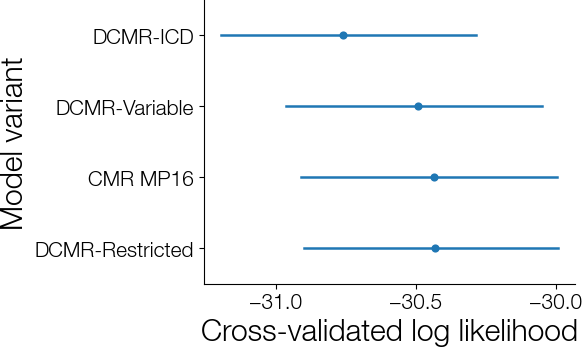

In [4]:
xval = framework.read_model_xvals(fit_dir, models, model_names)
g = figures.plot_xval_comp(xval, aspect=1.57, height=4)
g.savefig(fig_dir / 'model_comp_xval_subset.pdf');

## Plot best-fitting B parameters by sublayer

In [5]:
dark = sns.color_palette(
    'ch:start=1, rot=1.5, light=.7, dark=.3, gamma=1, hue=.5'
)
dark

[(0.7689335648950519, 0.6824396172757954, 0.6240123846554909),
 (0.7250187127782463, 0.5677430873950093, 0.6103083104698684),
 (0.623013021104788, 0.4855809829815538, 0.6161810850461853),
 (0.464634733019296, 0.4332443294049108, 0.5801730795425324),
 (0.31355069957273196, 0.3965359745123169, 0.4760973803152319),
 (0.2050147315167219, 0.34168808481661433, 0.31762490490999895)]

In [6]:
light = sns.color_palette(
    'ch:start=1, rot=1.5, light=.7, dark=.3, gamma=.5, hue=1'
)
light

[(0.9248203983802259, 0.8124754066629261, 0.7365856230946308),
 (0.9370151046580671, 0.7134152392755648, 0.773930517001042),
 (0.8638347057562072, 0.6485629096614572, 0.8531332480304541),
 (0.6875944308206159, 0.6323388125763083, 0.8909732355818533),
 (0.4826946089121227, 0.6491392670198295, 0.8087166257388984),
 (0.325484389760949, 0.649366831333291, 0.5923429764853889)]

In [7]:
ur_model = all_models[all_model_names.index("UR")]
fit = framework.read_model_fits(fit_dir, [ur_model], ["UR"])
B_names = [
    'B_enc_loc',
    'B_enc_cat',
    'B_enc_use',
    'B_rec_loc',
    'B_rec_cat',
    'B_rec_use',
]
B_subset = pd.melt(
    fit[B_names].reset_index(),
    id_vars='subject', 
    value_vars=B_names,
    var_name='parameter',
    value_name='value',
)
fit[B_names].reset_index()

,model,subject,B_enc_loc,B_enc_cat,B_enc_use,B_rec_loc,B_rec_cat,B_rec_use
0,UR,1,0.902936,3.308635e-02,0.846900,0.000000,1.000000,1.000000e+00
1,UR,2,0.699122,3.742264e-04,0.854216,0.803054,1.000000,9.977547e-01
2,UR,3,0.653284,3.034603e-02,0.002421,0.747189,1.000000,1.000000e+00
3,UR,5,0.523070,6.253567e-01,0.003237,0.623427,1.000000,3.387982e-02
4,UR,8,0.672541,6.162097e-01,0.591611,0.699485,0.997208,9.999447e-01
5,UR,11,0.190975,0.000000e+00,0.781990,0.200403,1.000000,1.000000e+00
6,UR,16,0.689417,1.353553e-01,0.475161,0.678517,1.000000,1.000000e+00
7,UR,18,0.463827,3.236991e-01,0.000000,0.646318,1.000000,1.000000e+00
8,UR,22,0.656636,2.108392e-01,0.142814,0.711868,1.000000,1.000000e+00
9,UR,23,0.590594,3.301902e-06,0.275770,0.769110,1.000000,1.000000e+00


/Users/nmorton/PycharmProjects/mindstorm/src/mindstorm/statplot.py:188: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.stripplot(data=data, x=x, y=y, hue=hue, ax=ax, **point_prop, **kwargs)
/Users/nmorton/PycharmProjects/mindstorm/src/mindstorm/statplot.py:203: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax, **bar_prop, **kwargs)
LINO NOT subset; don't know how to subset; dropped


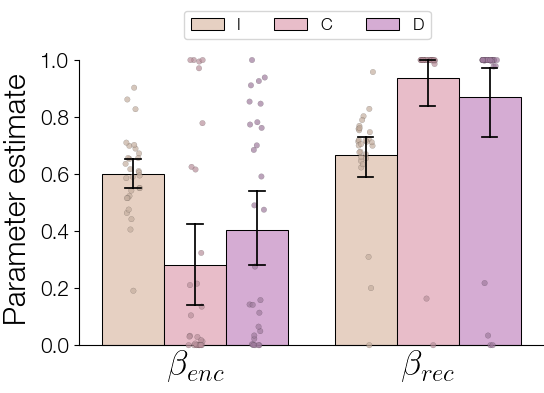

In [8]:
B_labels = [
    r'$\beta_\mathrm{enc}^{I}$',
    r'$\beta_\mathrm{enc}^{C}$',
    r'$\beta_\mathrm{enc}^{D}$',
    r'$\beta_\mathrm{rec}^{I}$',
    r'$\beta_\mathrm{rec}^{C}$',
    r'$\beta_\mathrm{rec}^{D}$',
]
B_subset['phase'] = B_subset['parameter'].map(
    {
        'B_enc_loc': 'enc',
        'B_enc_cat': 'enc',
        'B_enc_use': 'enc',
        'B_rec_loc': 'rec',
        'B_rec_cat': 'rec',
        'B_rec_use': 'rec',
    }
)
B_subset['sublayer'] = B_subset['parameter'].map(
    {
        'B_enc_loc': 'I',
        'B_enc_cat': 'C',
        'B_enc_use': 'D',
        'B_rec_loc': 'I',
        'B_rec_cat': 'C',
        'B_rec_use': 'D',
    }
)
fig, ax = plt.subplots(figsize=(6, 4))
statplot.plot_swarm_bar(
    B_subset,
    x='phase',
    y='value',
    hue='sublayer',
    point_kind='strip',
    light=light,
    dark=dark,
    dodge=True,
    bar_kws={'capsize': 0.2, 'clip_on': False},
    point_kws={'size': 4},
    legend=False,
    ax=ax,
)
ax.set(ylim=(0, 1), ylabel='Parameter estimate')
ax.set_xticks(
    [0, 1], 
    [r'$\beta_{enc}$', r'$\beta_{rec}$'], 
    usetex=True, 
    fontfamily='helvetica',
    fontsize='x-large',
)
ax.tick_params(axis='x', length=0)
ax.set(ylim=(0, 1.08), yticks=np.arange(0, 1.2, 0.2))
ax.spines['left'].set_bounds(0, 1)
fig.legend(loc=(.3375, .9), prop={'size': 12}, ncol=3)
ax.yaxis.set_label_coords(-.1, 0.475)
fig.savefig(fig_dir / 'param_B.pdf')

## Create parameter tables

In [9]:
table = reports.create_model_table(fit_dir, all_models, all_model_names, model_comp='xval')
table.to_latex(fig_dir / 'parameters2_full.tex', escape=False)
table

,I,C,D,IC,ID,CD,ICD,UR,EC-ED,RC-RD,EC-ED-RC-RD,I-CD
$L_{FC}$,0.13 (0.01),0.75 (0.00),0.61 (0.02),0.10 (0.01),0.11 (0.01),0.73 (0.01),0.10 (0.01),0.15 (0.02),0.08 (0.01),0.13 (0.02),0.08 (0.01),0.08 (0.01)
$L_{CF}$,0.11 (0.01),0.80 (0.01),0.69 (0.01),0.09 (0.01),0.10 (0.01),0.74 (0.01),0.09 (0.01),0.14 (0.02),0.08 (0.01),0.12 (0.02),0.08 (0.01),0.07 (0.01)
$D_{FF}$,---,---,---,---,---,---,---,---,---,---,---,0.14 (0.00)
$\phi_s$,0.39 (0.06),0.08 (0.00),0.22 (0.02),0.04 (0.00),0.08 (0.01),0.05 (0.00),0.03 (0.00),0.07 (0.01),0.02 (0.00),0.08 (0.01),0.02 (0.00),0.69 (0.14)
$\phi_d$,1.24 (0.13),0.52 (0.07),0.35 (0.02),1.81 (0.19),1.80 (0.18),0.46 (0.07),1.84 (0.18),1.21 (0.16),1.38 (0.18),1.23 (0.15),1.29 (0.17),1.57 (0.15)
$\beta_{\mathrm{enc}}$,0.71 (0.01),0.04 (0.00),0.10 (0.01),0.64 (0.01),0.66 (0.01),0.05 (0.01),0.62 (0.01),---,---,---,---,0.62 (0.01)
"$\beta_{\mathrm{enc},I}$",---,---,---,---,---,---,---,0.58 (0.02),0.62 (0.01),0.58 (0.02),0.63 (0.01),---
"$\beta_{\mathrm{enc},C}$",---,---,---,---,---,---,---,0.37 (0.05),1,0.39 (0.05),1,---
"$\beta_{\mathrm{enc},D}$",---,---,---,---,---,---,---,0.39 (0.04),1,0.42 (0.04),1,---
$\beta_{\mathrm{start}}$,0.62 (0.04),0.00 (0.00),0.03 (0.01),0.51 (0.04),0.61 (0.04),0.01 (0.01),0.50 (0.04),0.40 (0.04),0.68 (0.03),0.42 (0.04),0.71 (0.03),0.48 (0.04)


In [10]:
table = reports.create_model_table(fit_dir, models, model_names, model_comp='xval')
table.to_latex(fig_dir / 'parameters2.tex', escape=False)
table

,DCMR-ICD,DCMR-Variable,DCMR-Restricted,CMR MP16
$L_{FC}$,0.10 (0.01),0.15 (0.02),0.13 (0.02),0.08 (0.01)
$L_{CF}$,0.09 (0.01),0.14 (0.02),0.12 (0.02),0.07 (0.01)
$D_{FF}$,---,---,---,0.14 (0.00)
$\phi_s$,0.03 (0.00),0.07 (0.01),0.08 (0.01),0.69 (0.14)
$\phi_d$,1.84 (0.18),1.21 (0.16),1.23 (0.15),1.57 (0.15)
$\beta_{\mathrm{enc}}$,0.62 (0.01),---,---,0.62 (0.01)
"$\beta_{\mathrm{enc},I}$",---,0.58 (0.02),0.58 (0.02),---
"$\beta_{\mathrm{enc},C}$",---,0.37 (0.05),0.39 (0.05),---
"$\beta_{\mathrm{enc},D}$",---,0.39 (0.04),0.42 (0.04),---
$\beta_{\mathrm{start}}$,0.50 (0.04),0.40 (0.04),0.42 (0.04),0.48 (0.04)


In [11]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.16.1

mindstorm : 0.11.1
pandas    : 2.1.2
numpy     : 1.26.1
cfr       : 0.1.0
matplotlib: 3.8.0
seaborn   : 0.13.0

